__Étudiante__ : Madina TRAORÉ

#### Imports

In [2]:
import numpy as np
import time
from ipynb.fs.defs.mdp import maze_mdp # Markov Decision Process # RETIRER LES OCCURENCES DE "%notebook" DE mdp.py
                                       # POUR QUE CET IMPORT PUISSE SE FAIRE
from ipynb.fs.defs.maze_plotter import maze_plotter # used for visualization of the state value and policy evolution

# Model-Based Reinforcement Learning (MBRL)

We are now going to use Model-Based Reinforcement Learning (MBRL) techniques to solve our MDP. In the Model-Based approach, we learn a model of the transition and the reward function and apply Dynamic Programming (DP) techniques using this model instead of the true MDP.


## Real-Time Dynamic Programming (RTDP)

Let $\hat{P}^{(t)}$ denote the estimate of the transition probabilities at time $t$ (i.e., after the robot has experienced $t$ transitions and performed as many updates). The estimate $\hat{P}^{(t)}$ can then be updated as

$ \displaystyle \hat{P}^{(t+1)}(x_t, u_t, y) = (1 - \frac{1}{N_t(x_t, u_t)})\hat{P}^{(t)}(x_t, u_t, y) + \frac{1}{N_t(x_t, u_t)} \delta_y(x_{t+1})$

where $\delta_y(x) = 1$ if $y = x$ and 0 otherwise, and $N_t(x, u)$ denotes the number of visits to the (x, u) pair
up to and including time $t$. Note that, at time $t$, only the transition probabilities $\hat{P}^{(t)}(x_t, u_t, .)$
are updated, to reflect the new transition just observed. For the reward function estimate $\hat{r}$, we
simply have $\hat{r}^{(t+1)}(x_t, u_t) = r^{(t)}$.

Therefore, we don't have to estimate the reward function explicitly, i.e. we can use the reward samples instead.

Once $\hat{P}$ and $\hat{r}$ are properly estimated, we can now use them in a Value Iteration scheme.

An interesting aspect of the model-based approaches, however, is that these iterations can be
performed simultaneously with $\hat{P}$ and $\hat{r}$ updates. 

This technique is called Real-Time Dynamic Programming.

The code is provided below.

In [3]:
################################ Model-Based Reinforcement Learning ################################

# Learns a model of the transition function hatP and reward function hatR

########################### Real-Time Dynamic Programming ###########################


def RTDP(mdp, deviation=0, nEpisodes=10000, nTimesteps=50, render=True):  # Performs an estimation of the transition function hatP only (no reward estimation)
    # Deviation param is used to add some noise to the reward function      
    
    # Initialize state-action value function to zero
    Q = np.zeros((mdp.observation_space.size,mdp.action_space.size)) 
    
    # Initialize state function to a uniform distribution
    hatP = np.ones((mdp.observation_space.size+1,mdp.action_space.size,mdp.observation_space.size+1))/mdp.observation_space.size 
    
    # Initialize state-action count to one
    N = np.ones((mdp.observation_space.size,mdp.action_space.size))
    
    
    # Initialize Qmax, state value and policy lists
    Qmax = Q.max(axis=1)
    Q_list = [Q.copy()]
    policy_list = [np.argmax(Q,axis=1)]
    
    if render:
        mdp.new_render()
    
    mdp.timeout = nTimesteps
    
    for i in range(nEpisodes) : # For each episode
        
        # Draw an initial state (set uniform to False to sample according to P0 distribution)
        x = mdp.reset(uniform=True)
        done = mdp.done()
        while not done: 
            if render :
                    mdp.render(Q,Q.argmax(axis=1))
            
            # Draw an action randomly
            u = mdp.action_space.sample()
            
            # Perform a step forward in the MDP using action u
            [y,r,done,info] = mdp.step(u,deviation=deviation)

            # Update the transition function estimation hatP
            for k in mdp.observation_space.states :
                hatP[x,u,k] = (1-1/N[x,u])*(hatP[x,u,k])
            hatP[x,u,y] += 1/N[x,u]
            
            # Update state-action table based on the new hatP
            if x in mdp.terminal_states:
                Q[x,u] = r
            else:
                Q[x,u] = r + mdp.gamma*np.sum([hatP[x,u,k]*Qmax[k] for k in mdp.observation_space.states])
            Qmax = np.max(Q,axis=1)
        
            # Increment the counter
            N[x,u] = N[x,u]+1      
            
            # Update agent's position
            x = y

        # Save computed state-action value Q and policy
        Q_list.append(Q.copy())
        policy_list.append(Q.argmax(axis=1))
        
    if render :
        mdp.render(Q,Q.argmax(axis=1))
            
            
    return [Q_list,policy_list]


In [8]:
walls = [5,6]
height = 3
width = 3
terminal_states=[width*height-1]
m = maze_mdp(width, height, walls=walls, terminal_states=[height*width-1]) # maze-like MDP definition

In the cell below, write the code to run RTDP. How does it compare with Q-learning?

<IPython.core.display.Javascript object>


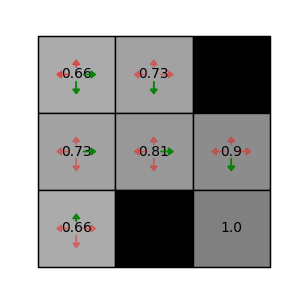

In [14]:
%matplotlib notebook

QPI_list, polPI_list = RTDP(m, deviation=0, nEpisodes=100, nTimesteps=50, render=True)

## RTPD for stochastic rewards

The code above only deals with deterministic rewards.

Modify the classes in [mdp.ipynb](mdp.ipynb) so as to add a Gaussian noise of standard deviation 0.1 to the reward (see the function np.random.randn()). What happens if you set the standard deviation to 1.0? 

Copy-paste the RTDP code above in the cell below, and update it so as to deal with stochastic rewards.

In [16]:
def stochastic_RTDP(mdp, deviation=0.1, nEpisodes=10000, nTimesteps=50, render=True):  # Performs an estimation of the transition function hatP only (no reward estimation)
    # Deviation param is used to add some noise to the reward function      
    
    # Initialize state-action value function to zero
    Q = np.zeros((mdp.observation_space.size,mdp.action_space.size)) 
    
    # Initialize state function to a uniform distribution
    hatP = np.ones((mdp.observation_space.size+1,mdp.action_space.size,mdp.observation_space.size+1))/mdp.observation_space.size 
    
    # Initialize state-action count to one
    N = np.ones((mdp.observation_space.size,mdp.action_space.size))
    
    
    # Initialize Qmax, state value and policy lists
    Qmax = Q.max(axis=1)
    Q_list = [Q.copy()]
    policy_list = [np.argmax(Q,axis=1)]
    
    if render:
        mdp.new_render()
    
    mdp.timeout = nTimesteps
    
    for i in range(nEpisodes) : # For each episode
        
        # Draw an initial state (set uniform to False to sample according to P0 distribution)
        x = mdp.reset(uniform=True)
        done = mdp.done()
        while not done: 
            if render :
                    mdp.render(Q,Q.argmax(axis=1))
            
            # Draw an action randomly
            u = mdp.action_space.sample()
            
            # Perform a step forward in the MDP using action u
            [y,r,done,info] = mdp.step(u,deviation=deviation)

            # Update the transition function estimation hatP
            for k in mdp.observation_space.states :
                hatP[x,u,k] = (1-1/N[x,u])*(hatP[x,u,k])
            hatP[x,u,y] += 1/N[x,u]
            
            # Update state-action table based on the new hatP
            if x in mdp.terminal_states:
                Q[x,u] = r
            else:
                Q[x,u] = r + mdp.gamma*np.sum([hatP[x,u,k]*Qmax[k] for k in mdp.observation_space.states])
            Qmax = np.max(Q,axis=1)
        
            # Increment the counter
            N[x,u] = N[x,u]+1      
            
            # Update agent's position
            x = y

        # Save computed state-action value Q and policy
        Q_list.append(Q.copy())
        policy_list.append(Q.argmax(axis=1))
        
    if render :
        mdp.render(Q,Q.argmax(axis=1))
            
            
    return [Q_list,policy_list]


<IPython.core.display.Javascript object>


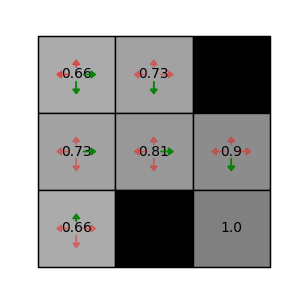

In [19]:
%matplotlib notebook

Q_list, policy_list = stochastic_RTDP(m, deviation=0.1, nEpisodes=100, nTimesteps=50, render=True)

In [13]:
start_time = time.time()
Q_list, policy_list = stochastic_RTDP(m, deviation=0.1, nEpisodes=100, nTimesteps=50, render=False)
t = time.time() - start_time
print("Temps d'exécution :",t)

Temps d'exécution : 0.20753026008605957


<IPython.core.display.Javascript object>


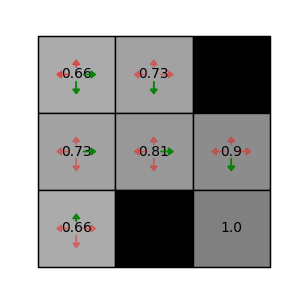

In [14]:
%matplotlib notebook

Q_list, policy_list = stochastic_RTDP(m, deviation=1, nEpisodes=100, nTimesteps=50, render=True)

Here is some code to visualize the RTDP process after having run your code above.

sample length :  101
nb of frames :  50
step size :  2


<IPython.core.display.Javascript object>


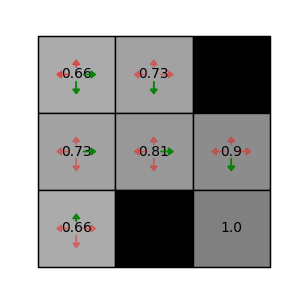

In [8]:
# visualize your results
%matplotlib notebook

from ipynb.fs.defs.maze_plotter import maze_plotter # used to generate a video describing the state value and policy evolution
from IPython.display import HTML # used to display the video inside the notebook

nb_frames = 50
ani = m.create_animation(Q_list, policy_list, nb_frames)
HTML(ani.to_jshtml()) # loads your video and enables a video widget
